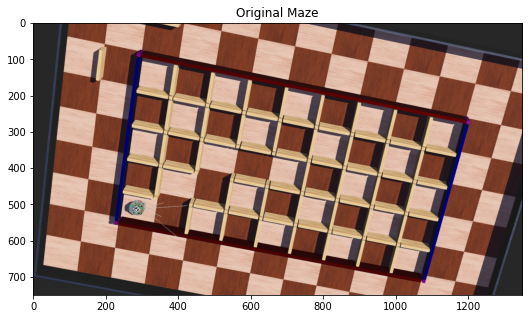

In [1]:
# import required libraries
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting

# definitions
MAZE_FILE_NAME = 'PHASEC_TEST_IMAGES/Maze_4.png'
ROBOT_FILE_NAME = 'PHASEC_TEST_IMAGES/Robot_4.png'
MAP_FILE_NAME = 'MapFound.txt'
MAZE_ROWS = 5
MAZE_COLS = 9
# read images
maze_bgr = cv2.imread(MAZE_FILE_NAME)
maze_rgb = cv2.cvtColor(maze_bgr, cv2.COLOR_BGR2RGB)
maze_gray = cv2.cvtColor(maze_bgr, cv2.COLOR_BGR2GRAY)
maze_hsv = cv2.cvtColor(maze_bgr, cv2.COLOR_BGR2HSV)
robot_bgr = cv2.imread(ROBOT_FILE_NAME)
robot_rgb = cv2.cvtColor(robot_bgr, cv2.COLOR_BGR2RGB)
robot_gray = cv2.cvtColor(robot_bgr, cv2.COLOR_BGR2GRAY)
robot_hsv = cv2.cvtColor(robot_bgr, cv2.COLOR_BGR2HSV)

# display maze
plt.figure(figsize = (9, 5))
plt.imshow(maze_rgb)
plt.title('Original Maze')
plt.show()

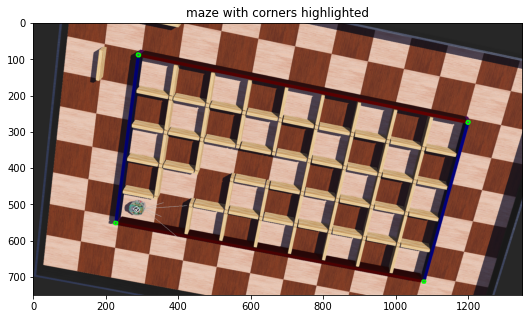

In [23]:
# find the corners by thresholding the image for the corners
# search for corners in each ROI

# create ranges for threshold
corner_lower = np.array([140, int(0.22*255), int(0.45*255)])
corner_upper = np.array([160, 255, 255])

# threshold the hsv image
corner_mask = cv2.inRange(maze_hsv, corner_lower, corner_upper)
kernel = np.ones((3, 3), np.uint8)

corner_mask_ = cv2.morphologyEx(corner_mask, cv2.MORPH_OPEN, kernel)
# corner_mask_ = cv2.morphologyEx(corner_mask_, cv2.MORPH_CLOSE, kernel)
# corner_mask_ = cv2.dilate(corner_mask_, kernel, iterations = 3)
edges = cv2.Canny(corner_mask_, threshold1 = 50, threshold2 = 100, apertureSize = 5)

maze_with_corners = maze_rgb.copy() # get a copy of the original bgr and draw markers on it for corners
img2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(maze_with_corners, contours, -1, (0, 255, 0), 3)

# display maze
plt.figure(figsize = (9, 5))
plt.imshow(maze_with_corners)
plt.title('maze with corners highlighted')
plt.show()


# cv2.imshow('corners', corner_mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# cv2.imshow('corners_closed', corner_mask_)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# cv2.imshow('maze_corners', maze_with_corners)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


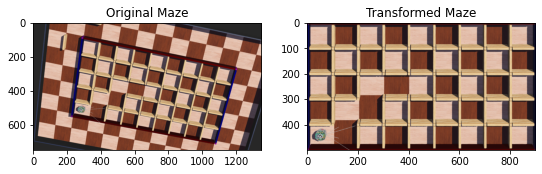

In [24]:
# grab centres of each corner for perspective transform later
# default centres are in centre of each ROI
corner_centres = np.float32([[169,187],[1181,187],[169,562],[1181,562]])
for i, cnt in enumerate(contours):
    M = cv2.moments(cnt)
    cy = int(M['m01']/M['m00'])
    cx = int(M['m10']/M['m00'])
    if (0 <= cy <= 375 and 0 <= cx <= 338):
        corner_centres[0][0] = cx
        corner_centres[0][1] = cy
    if (0 <= cy <= 375 and 1012 <= cx <= 1350):
        corner_centres[1][0] = cx
        corner_centres[1][1] = cy
    if (375 <= cy <= 750 and 0 <= cx <= 338):
        corner_centres[2][0] = cx
        corner_centres[2][1] = cy
    if (375 <= cy <= 750 and 1012 <= cx <= 1350):
        corner_centres[3][0] = cx
        corner_centres[3][1] = cy
#     print("centre of corners = [", cy, ",", cx, "]")
# print(corner_centres)
dst_res = np.float32([[0,0],[900,0],[0,500],[900,500]])
H = cv2.getPerspectiveTransform(corner_centres, dst_res)
# print(H)
maze_tf = cv2.warpPerspective(maze_rgb, H, (900,500))

# display maze
fig, (ax1, ax2) = plt.subplots(figsize = (9, 5), ncols = 2)
ax1.imshow(maze_rgb), ax1.set_title("Original Maze")
ax2.imshow(maze_tf), ax2.set_title("Transformed Maze")
plt.show()

maze_tf_hsv = cv2.cvtColor(maze_tf, cv2.COLOR_RGB2HSV)
maze_tf_gray = cv2.cvtColor(maze_tf, cv2.COLOR_RGB2GRAY)
maze_tf_bgr = cv2.cvtColor(maze_tf, cv2.COLOR_RGB2BGR)

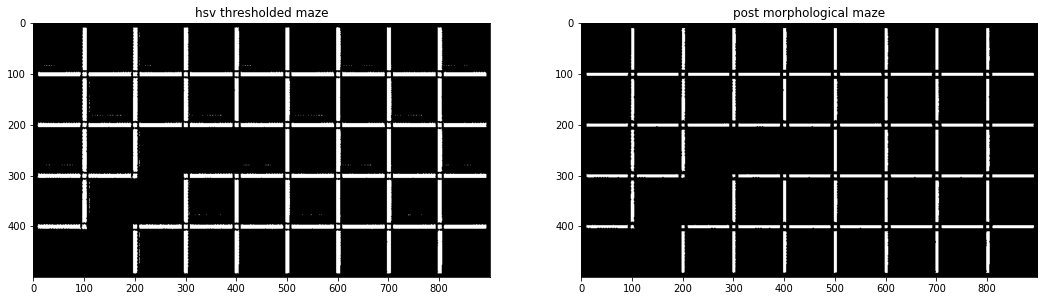

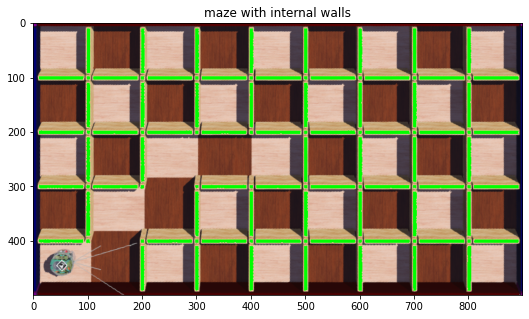

In [25]:
# contour detection of internal walls using hsv thresholding
wall_lower = np.array([13, 0, 220])
wall_upper = np.array([35, 255, 255])

wall_mask = cv2.inRange(maze_tf_hsv, wall_lower, wall_upper)

kernel = np.ones((3, 3), np.uint8)

wall_mask_ = cv2.morphologyEx(wall_mask, cv2.MORPH_OPEN, kernel)
wall_mask_ = cv2.morphologyEx(wall_mask_, cv2.MORPH_OPEN, kernel)

# wall_mask_ = cv2.morphologyEx(wall_mask_, cv2.MORPH_CLOSE, kernel)

# wall_mask_ = cv2.morphologyEx(wall_mask_, cv2.MORPH_CLOSE, kernel)

# wall_mask_ = cv2.morphologyEx(wall_mask_, cv2.MORPH_CLOSE, kernel)
# kernel = np.ones((4, 4), np.uint8)
# wall_mask_ = cv2.morphologyEx(wall_mask_, cv2.MORPH_CLOSE, kernel)
wall_mask_ = cv2.erode(wall_mask_, kernel, iterations =  1)


edges = cv2.Canny(wall_mask_, threshold1 = 50, threshold2 = 100, apertureSize = 3)

maze_with_wall = maze_tf_bgr.copy()
img2, wall_contours, hierarchy = cv2.findContours(wall_mask_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(maze_with_wall, wall_contours, -1, (0, 255, 0), -1)

fig, (ax1, ax2) = plt.subplots(figsize = (18, 10), ncols = 2)
ax1.imshow(wall_mask, cmap='gray'), ax1.set_title("hsv thresholded maze")
ax2.imshow(wall_mask_, cmap='gray'), ax2.set_title("post morphological maze")
plt.show()


maze_with_wall_hsv = cv2.cvtColor(maze_with_wall, cv2.COLOR_BGR2HSV)
maze_with_wall_gray = cv2.cvtColor(maze_with_wall, cv2.COLOR_BGR2GRAY)
maze_with_wall_rgb = cv2.cvtColor(maze_with_wall, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (9, 5))
plt.imshow(maze_with_wall_rgb)
plt.title('maze with internal walls')
plt.show()


In [26]:
# detect aruco marker in robot.png to determine heading of robot

# Load the predefined dictionary
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)

# Initialize the detector parameters using default values
parameters =  cv2.aruco.DetectorParameters_create()

# Detect the markers in the image
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robot_rgb, dictionary, parameters=parameters)
# first corner is the blue corner that indicates heading of robot... in [col, row] form
# print(markerCorners)
head_corner = markerCorners[0][0][0]
marker_corner_rows = np.array([markerCorners[0][0][0][1], markerCorners[0][0][1][1], markerCorners[0][0][2][1], markerCorners[0][0][3][1]])
marker_corner_cols = np.array([markerCorners[0][0][0][0], markerCorners[0][0][1][0], markerCorners[0][0][2][0], markerCorners[0][0][3][0]])
# print(head_corner)
# print(marker_corner_rows)
# print(marker_corner_cols)

heading = 'Nothing'

if (head_corner[1] == min(marker_corner_rows)):
    # if corner is lowest row value then N
    heading = '^'
elif (head_corner[1] == max(marker_corner_rows)):
    # if corner is highest row calue then S
    heading = 'v'
elif (head_corner[0] == min(marker_corner_cols)):
    # if corner is lowest col value then W
    heading = '<'
elif (head_corner[0] == max(marker_corner_cols)):
    # if corner is highest col value then E
    heading = '>'

print(heading)

>


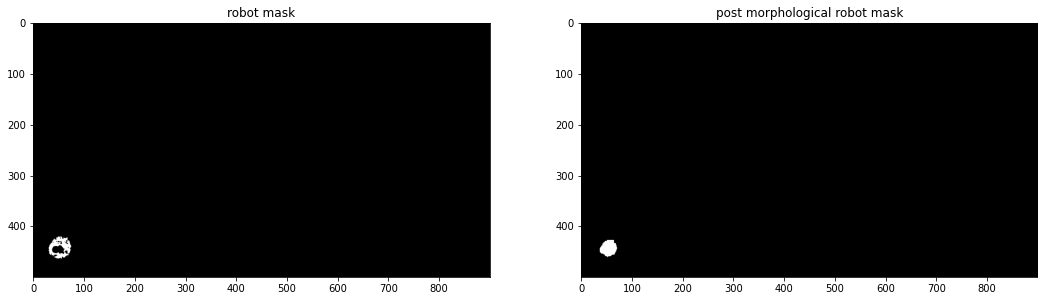

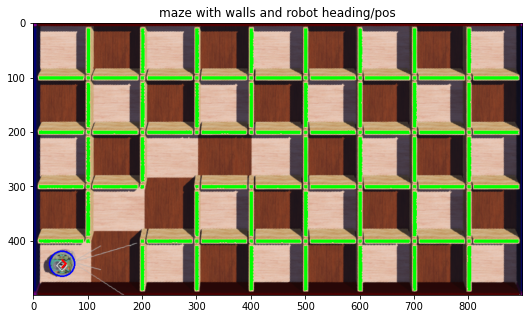

In [27]:
# detecting location of robot using hsv thresholding and draw heading on robot
robot_lower = np.array([33, 0, 0])
robot_upper = np.array([108, 255, 255])

robot_mask = cv2.inRange(maze_tf_hsv, robot_lower, robot_upper)

kernel = np.ones((20, 20), np.uint8)
robot_mask_ = cv2.morphologyEx(robot_mask, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((9, 9), np.uint8)
# robot_mask_ = cv2.morphologyEx(robot_mask_, cv2.MORPH_CLOSE, kernel)
robot_mask_ = cv2.erode(robot_mask_, kernel, iterations = 1)

fig, (ax1, ax2) = plt.subplots(figsize = (18, 10), ncols = 2)
ax1.imshow(robot_mask, cmap='gray'), ax1.set_title("robot mask")
ax2.imshow(robot_mask_, cmap='gray'), ax2.set_title("post morphological robot mask")
plt.show()


edges = cv2.Canny(robot_mask_, threshold1 = 50, threshold2 = 100, apertureSize = 3)

img2, robot_contours, hierarchy = cv2.findContours(robot_mask_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(robot_contours)
robot_cnts = 0
robot_centre = [0,0]
for i, cnt in enumerate(robot_contours):
    M = cv2.moments(robot_contours[i])
    if (M['m00'] == 0):
        continue
    else:
        robot_cnts += 1
        cy = int(M['m01']/M['m00'])
        cx = int(M['m10']/M['m00'])
        robot_centre[0] += cx
        robot_centre[1] += cy
    # print("centre of robot = [", cy, ",", cx, "]")
robot_centre[0] = robot_centre[0]//robot_cnts
robot_centre[1] = robot_centre[1]//robot_cnts
robot_centre = tuple(robot_centre)
# print(robot_centre)
# draw heading arrow of robot based upon centre of robot
offset = 7
# Red color in BGR 
color = (0, 0, 255)
# Line thickness of 2 px 
thickness = 2

color = (0, 0, 255)
if (heading == '^'):
    start_point = (robot_centre[0], robot_centre[1]-offset)
    end_point = (robot_centre[0]+offset, robot_centre[1]) 
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness) 
    end_point = (robot_centre[0]-offset, robot_centre[1])
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness) 
elif (heading == 'v'):
    start_point = (robot_centre[0], robot_centre[1]+offset)
    end_point = (robot_centre[0]+offset, robot_centre[1]) 
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness) 
    end_point = (robot_centre[0]-offset, robot_centre[1])
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness) 
elif (heading == '<'):
    start_point = (robot_centre[0]-offset, robot_centre[1])
    end_point = (robot_centre[0], robot_centre[1]-offset) 
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness) 
    end_point = (robot_centre[0], robot_centre[1]+offset)
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness)
elif (heading == '>'):
    start_point = (robot_centre[0]+offset, robot_centre[1])
    end_point = (robot_centre[0], robot_centre[1]-offset) 
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness) 
    end_point = (robot_centre[0], robot_centre[1]+offset)
    maze_with_wall = cv2.line(maze_with_wall, tuple(start_point), tuple(end_point), color, thickness)

# draw robot position circle
color = (255, 0, 0)
maze_with_wall = cv2.circle(maze_with_wall, robot_centre, 23, color, thickness)
temp = cv2.cvtColor(maze_with_wall, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (9, 5))
plt.imshow(temp)
plt.title('maze with walls and robot heading/pos')
plt.show()


In [28]:
# identify walls in internal wall detection and draw over walls then match to construct text file
# use wall_contours to identify walls in certain regions to construct the map
# area of contour must be large enough as to NOT detect the posts in the maze > 100 for it to be a wall
# robot_idx = (int(robot_centre[1]/100), int(robot_centre[0]/100))
# robot is always in one of the corners so we can account for the cases separately
robot_idx = [int(robot_centre[1]/100), int(robot_centre[0]/100)]
if (robot_centre[1] <= 150):
    robot_idx[0] = 0
elif (robot_centre[1] >= 350):
    robot_idx[0] = 4
if (robot_centre[0] <= 150):
    robot_idx[1] = 0
elif (robot_centre[0] >= 750):
    robot_idx[1] = 8
robot_idx = tuple(robot_idx)
# print(robot_idx)
# construct vertical and horizontal wall matrices for ease of making map txt file
vWall = np.zeros((MAZE_ROWS, MAZE_COLS+1))
hWall = np.zeros((MAZE_ROWS+1, MAZE_COLS))
for i in range(MAZE_ROWS):
    vWall[i][0] = 1
    vWall[i][-1] = 1
for i in range(MAZE_COLS):
    hWall[0][i] = 1
    hWall[-1][i] = 1

wall_centre_error = 25

walls_ = 0
for i, cnt in enumerate(wall_contours):
    M = cv2.moments(cnt)
    if (M['m00'] != 0):
        cy = int(M['m01']/M['m00'])
        cx = int(M['m10']/M['m00'])
        area = cv2.contourArea(cnt)
        # print("area = ", area)
        if (area > 100):
            walls_ += 1

            if (50 - wall_centre_error <= cy % 100 <= 50 + wall_centre_error):
                # we are looking at a vertical wall
                # print("vertical wall: ", end='')
                vWall[int(cy/100)][int(round(cx/100))] = 1
                # print("wall matrix index = [", int(cy/100), ",", int(round(cx/100)), "]")

            if (50 - wall_centre_error <= cx % 100 <= 50 + wall_centre_error):
                # we are looking at a horizontal wall
                # print("horizontal wall: ", end='')
                hWall[int(round(cy/100))][int(cx/100)] = 1
                # print("wall matrix index = [", int(round(cy/100)), ",", int(cx/100), "]")

    # print("centre of contour = [", cy, ",", cx, "]")
    
# print(walls_)
# print(hWall)
# print(vWall)


map = ''
for r in range(11):
    if (r % 2 == 0):
        # concatenate horizontal walls
        map += ' '
        for c in range(9):
            if (hWall[r//2][c] == 1):
                map += '---'
            else:
                map += '   '
            map += ' '
    else:
        # concatentate vertical walls OR robot heading
        for c in range(10):
            if (vWall[r//2][c] == 1):
                map += '|'
            else:
                map += ' '
            if (c <= 8):
                if (r//2 == robot_idx[0] and c//1 == robot_idx[1]):
                    map += ' '
                    map += heading
                    map += ' '
                else:
                    map += '   '
    if (r <= 9):
        map += '\n'

# write the map to a file MapFound.txt
print(map)
f = open(MAP_FILE_NAME, "w")
f.write(map)
f.close()


 --- --- --- --- --- --- --- --- --- 
|   |   |   |   |   |   |   |   |   |
 --- --- --- --- --- --- --- --- --- 
|   |   |   |   |   |   |   |   |   |
 --- --- --- --- --- --- --- --- --- 
|   |   |           |   |   |   |   |
 --- ---     --- --- --- --- --- --- 
|   |       |   |   |   |   |   |   |
 ---     --- --- --- --- --- --- --- 
| >     |   |   |   |   |   |   |   |
 --- --- --- --- --- --- --- --- --- 
